In [10]:
import sys

import pandas as pd

import superlets_package.superlets

sys.path.insert(0, '..')

In [11]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import importlib
import time

import superlets_package.morlet as superlets_module_morlet
import superlets_package.superlets as superlet

#from superlets_package.superlets import wavelet_transform, adaptive_superlet_transform, fdeluca_changing, compute_psd_welch, meanfreq, instant_mean

We first generate a signal similar to that used in Fig. 3 of the paper. For this demo, we use three bursts 11 cycles long, with frequency 20Hz, 40Hz and 60Hz each. Each burst is "contaminated" by neighbors both in time and frequency. The neighbors in frequency are 10Hz higher than the original values overlapping with the original signal, while the neighbors in time begin 2 cycles later, and last for 12 cycles. The entire signal is generated with a sampling rate of 1024 samples per second.

### SIMULATED SIGNAL = SIN + COS

In [12]:
fs = 1024
burst_freqs = [110]
f_shift = 10
n_cycles = 11
n_neighb_cycles = 12
# 
ys = []
# 
# # create a 0.1s blank signal to start
ys.append(jnp.zeros(int(fs*0.1)))
# 
for f in burst_freqs:
#   # frequency contaminated signal
#   ############ CONTAMINATION
#   t = 1/f * n_cycles
#   x = jnp.linspace(0, t, int(t * fs))
#   y = jnp.sin(2*jnp.pi*f*x) + jnp.sin(2*jnp.pi*(f+f_shift)*x - jnp.pi/1.5)
#   ys.append(y)
#   ############ CONTAMINATION
# 
#   # time contaminated signal, 2 cycles later
  ys.append(jnp.zeros(int(fs*(1/f)*2)))
#   
  t2 = 1/f * n_neighb_cycles
  x = jnp.linspace(0, t2, int(t2 * fs))
  y = jnp.sin(2*jnp.pi*f*x)
  ys.append(y)
# 
#   # space between bursts of 0.1s
  ys.append(jnp.zeros(int(fs*0.1)))
# 
signal = jnp.concatenate(ys)

### SIMULATED SIGNAL = CHIRP SIGNAL

In [13]:
# from scipy.signal import chirp
# 
# fs = 1000  
# t = np.arange(0, 5, 1/fs) # Time from 0 to 5 seconds
# f0 = 200  # Initial frequency
# f1 = 10  # Final frequency
#  
# signal = chirp(t, f0=f0, t1=t[-1], f1=f1, method='linear')

In [14]:
fs = 1024
t = np.linspace(0, 10, 10 * fs)
noise = np.random.normal(0, 0.01, len(t))  # Gaussian noise
#noise = np.zeros(len(t))
baseline_1 = noise.copy()

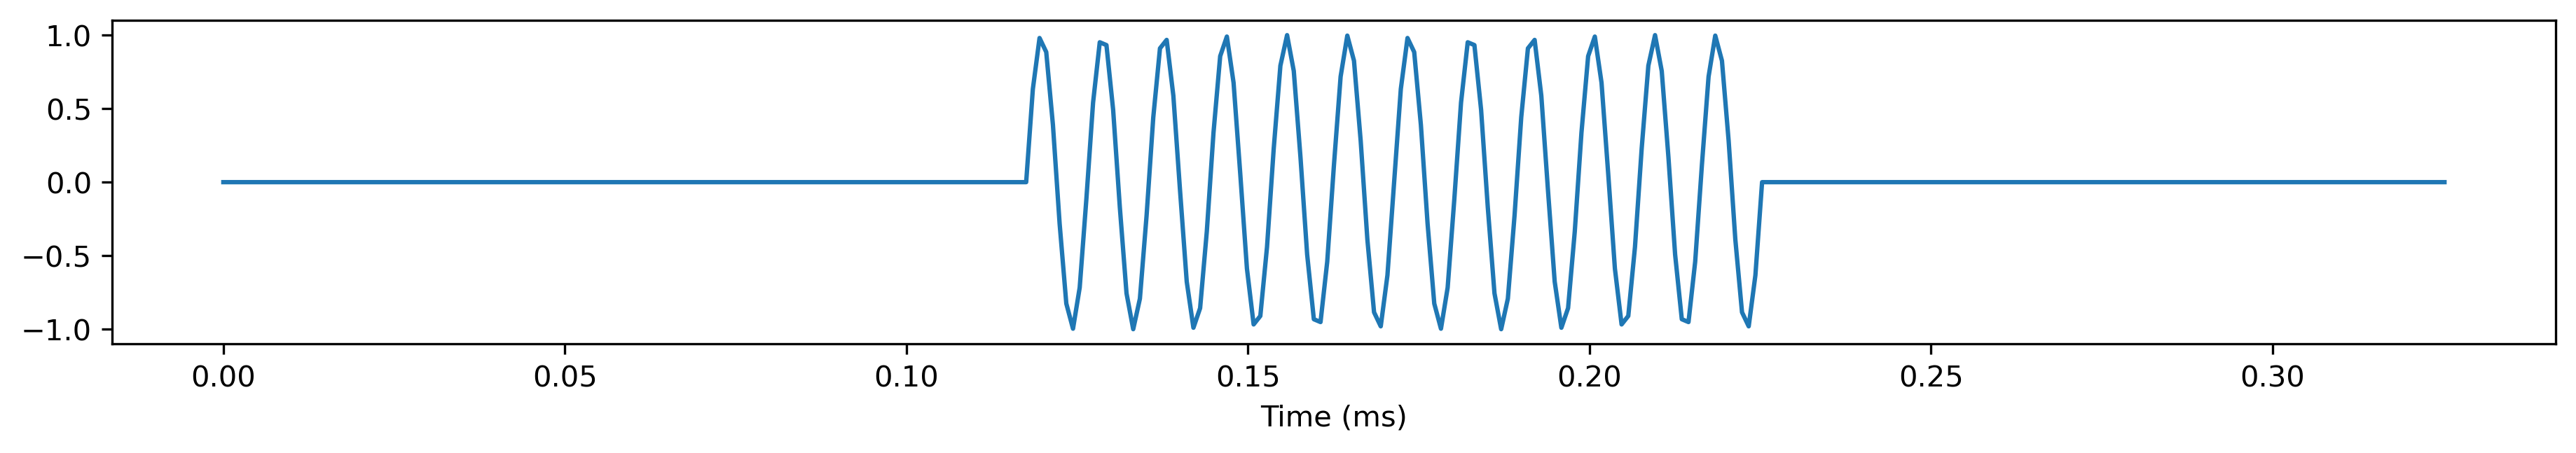

In [15]:
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal)/fs, len(signal)), signal)

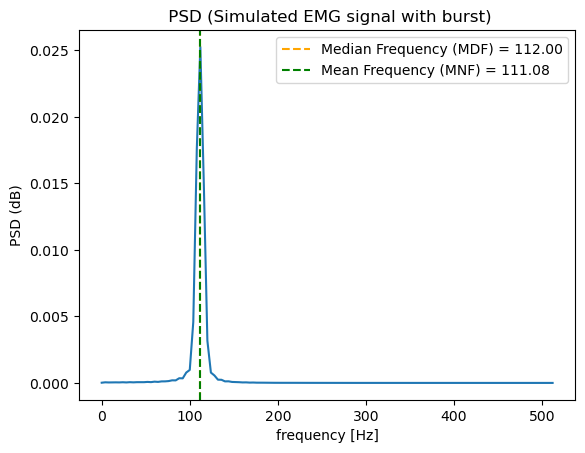

In [17]:
psd_welch, f_welch, MNF = superlet.compute_psd_welch(signal, fs, plot=True, muscle='Simulated EMG signal with burst')

We first apply regular wavelet transforms to the signal, with wavelets of 3, 16 and 33 cycles long, respectively. Note that we specifically use the complex Morlet wavelet for both the wavelet and superlet transforms.

In [18]:
def calculate_mae(estimates, true_value):
    errors = np.abs(np.array(estimates) - true_value)
    mae = np.mean(errors)
    std_error = np.std(errors)
    return mae, std_error

In [23]:
freqs = jnp.linspace(30,150,413) # Número de puntos del vector frecuencia

## WAVELET PARAMETERS = 3, 16, 33 cycles

In [24]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

In [25]:
total_scalogram_wavelet = []

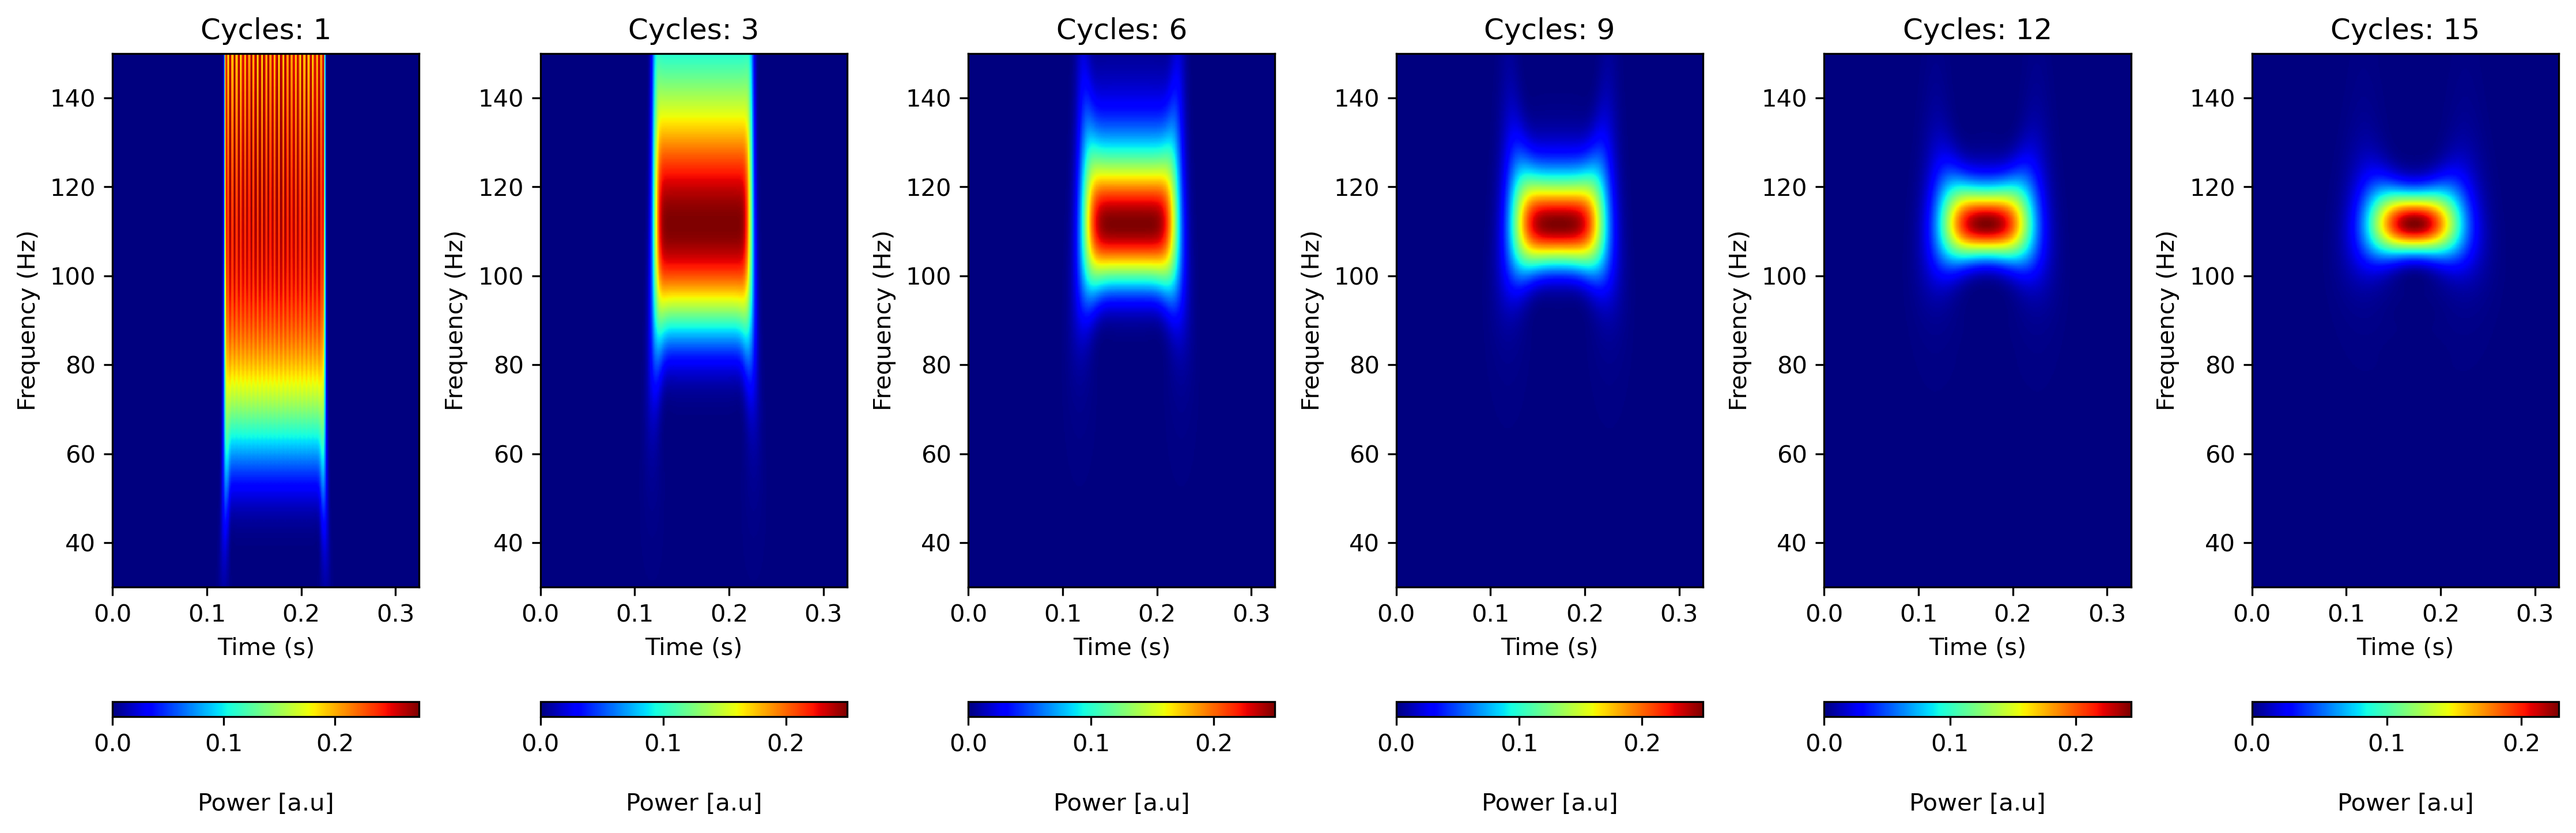

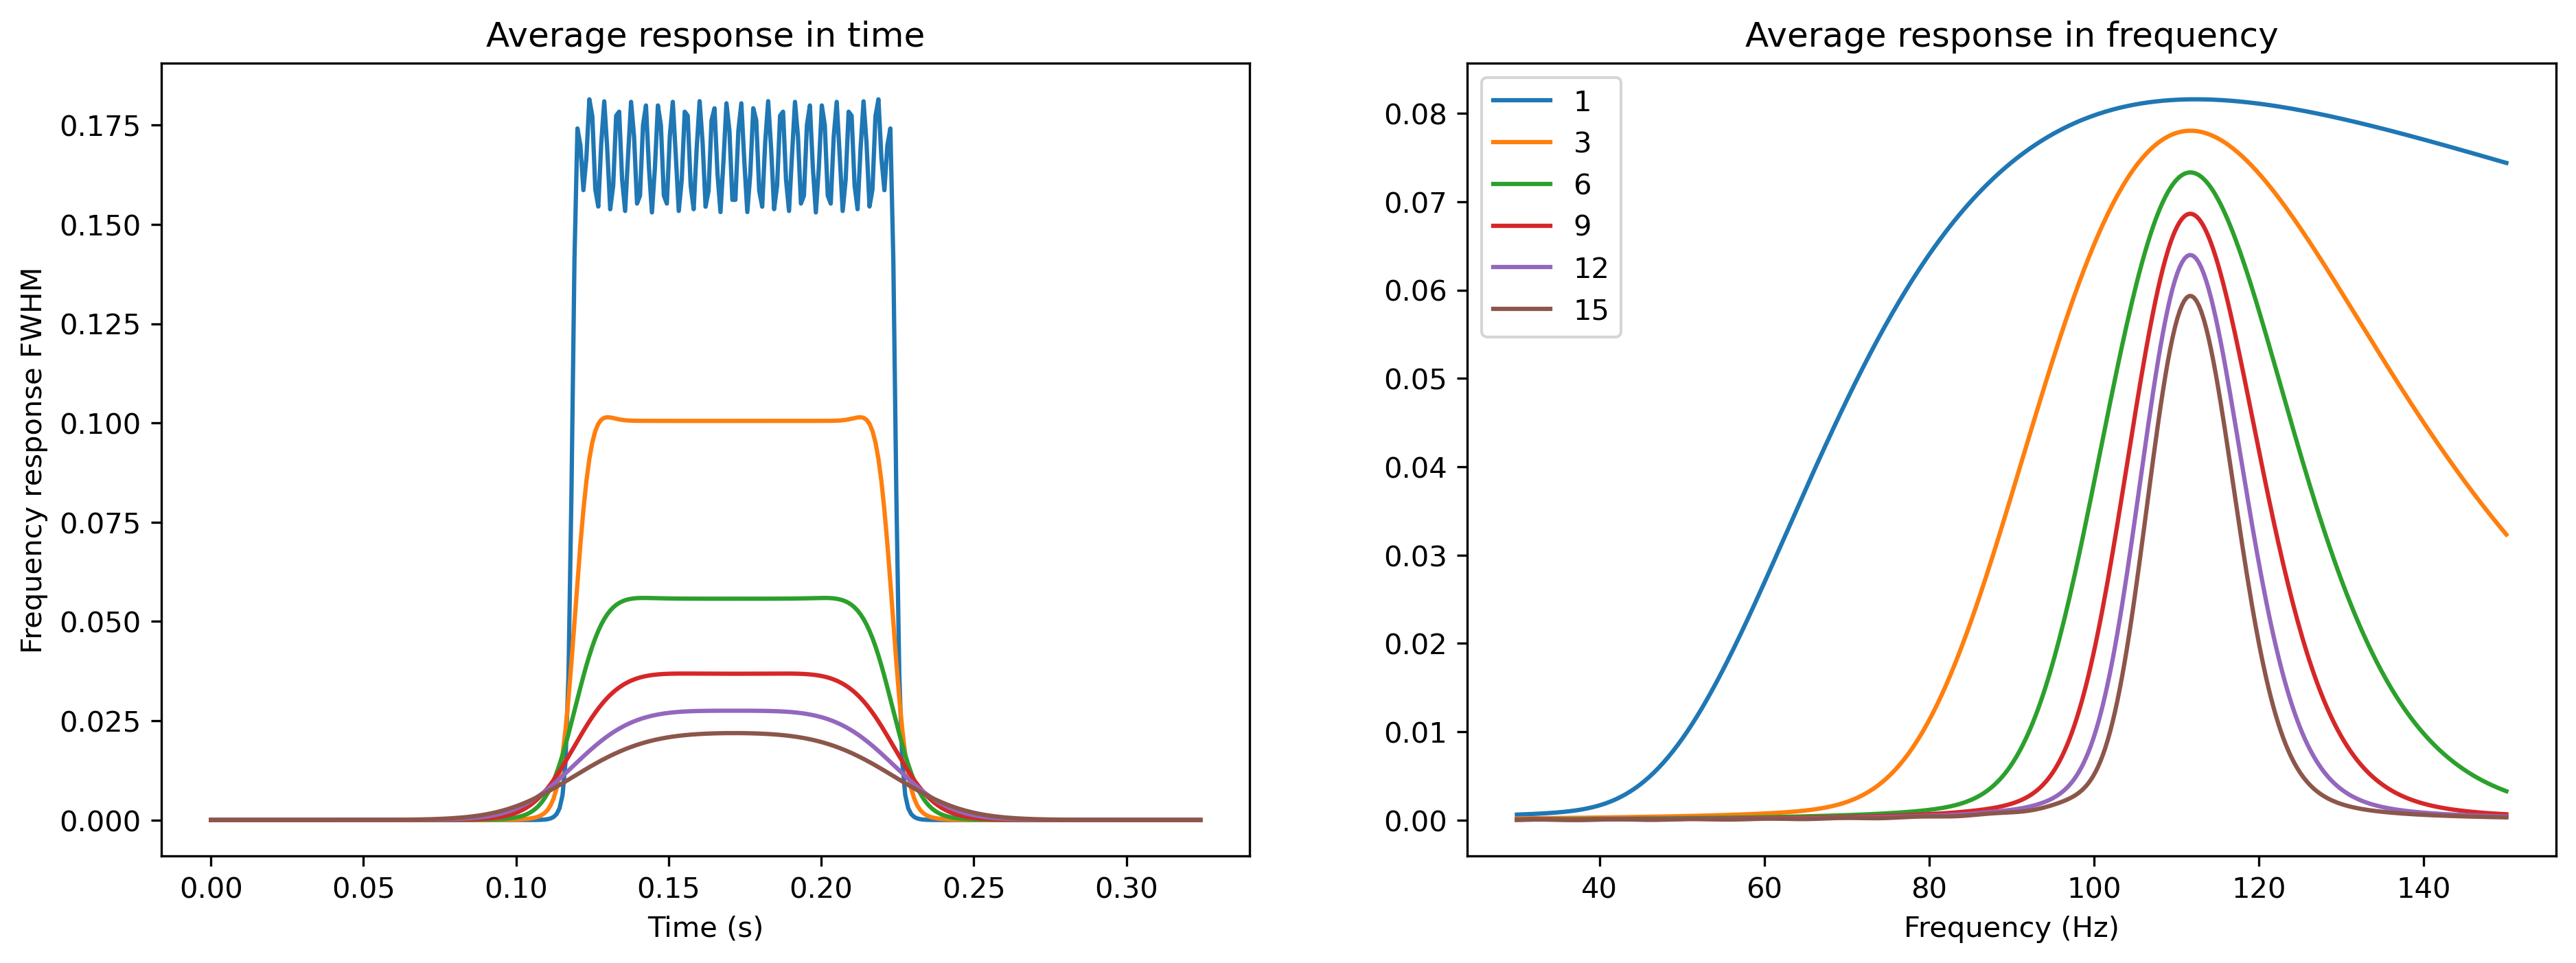

In [26]:
#params_wavelet = [3,16,33]
params_wavelet = [1, 3, 6, 9, 12, 15]
fig, ax = plt.subplots(ncols=len(params_wavelet), figsize=(15, 5), dpi=300)

total_time = []
total_freq = []

for i, c in enumerate(params_wavelet):
    [wv, scalogram] = superlet.wavelet_transform(signal, freqs, c, fs)

    im = ax[i].imshow(jnp.abs(scalogram)**2, aspect='auto', cmap="jet", interpolation="none", origin="lower", extent=[0, len(signal)/fs, freqs[0], freqs[-1]]) #, vmin=vmin, vmax=vmax)
    ax[i].set_title(f"Cycles: {c}")
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Frequency (Hz)")

    cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
    cbar.set_label('Power [a.u]', rotation=0, labelpad=15)  # Etiqueta de la colorbar
    
    #mean_freq = sum(power.*frequencies)/sum(power)
    #instant_mean.append(meanfreq(scalogram[:, col], freqs) for col in range(scalogram.shape[1]))
    
    scalogram_2 = np.abs(scalogram)**2    
    
    if np.any(np.isnan(jnp.abs(scalogram)**2)) or np.any(np.isinf(jnp.abs(scalogram)**2)):
        scalogram_2 = np.nan_to_num(jnp.abs(scalogram)**2)
        
    total_scalogram_wavelet.append(scalogram_2)

    # Create time (each column is a time instant)
    time = np.arange(scalogram_2.shape[1]) / fs
    
    total_time.append(time)
    total_freq.append(freqs)
    
plt.tight_layout()
    
res_wavelet = superlet.compute_avg_response_resolution(total_scalogram_wavelet, total_time, total_freq, params_wavelet)

There's a tradeoff above; using a low number of cycles results in high temporal resolution, but poor frequency resolution (the activations are "smeared" on the frequency dimension). On the other hand, a high number of cycles results in high frequency resolution, but poor temporal resolution. 

There are fundamental limits to how precise we can be on *both* aspects without making a tradeoff on either (the Gabor limit), but the standard wavelet transform isn't on that optimal boundary. Superlets improve resolution on both (time *and* frequency) by taking the geometric mean of wavelet transforms of different cycle lengths, more tightly approaching the Gabor limit.

## SUPERLET PARAMETERS: base_cycle, min_order, max_order = [3, 5, 1], [1, 1, 5], [30, 30, 40]

In [27]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

In [28]:
total_scalogram_superlet = []

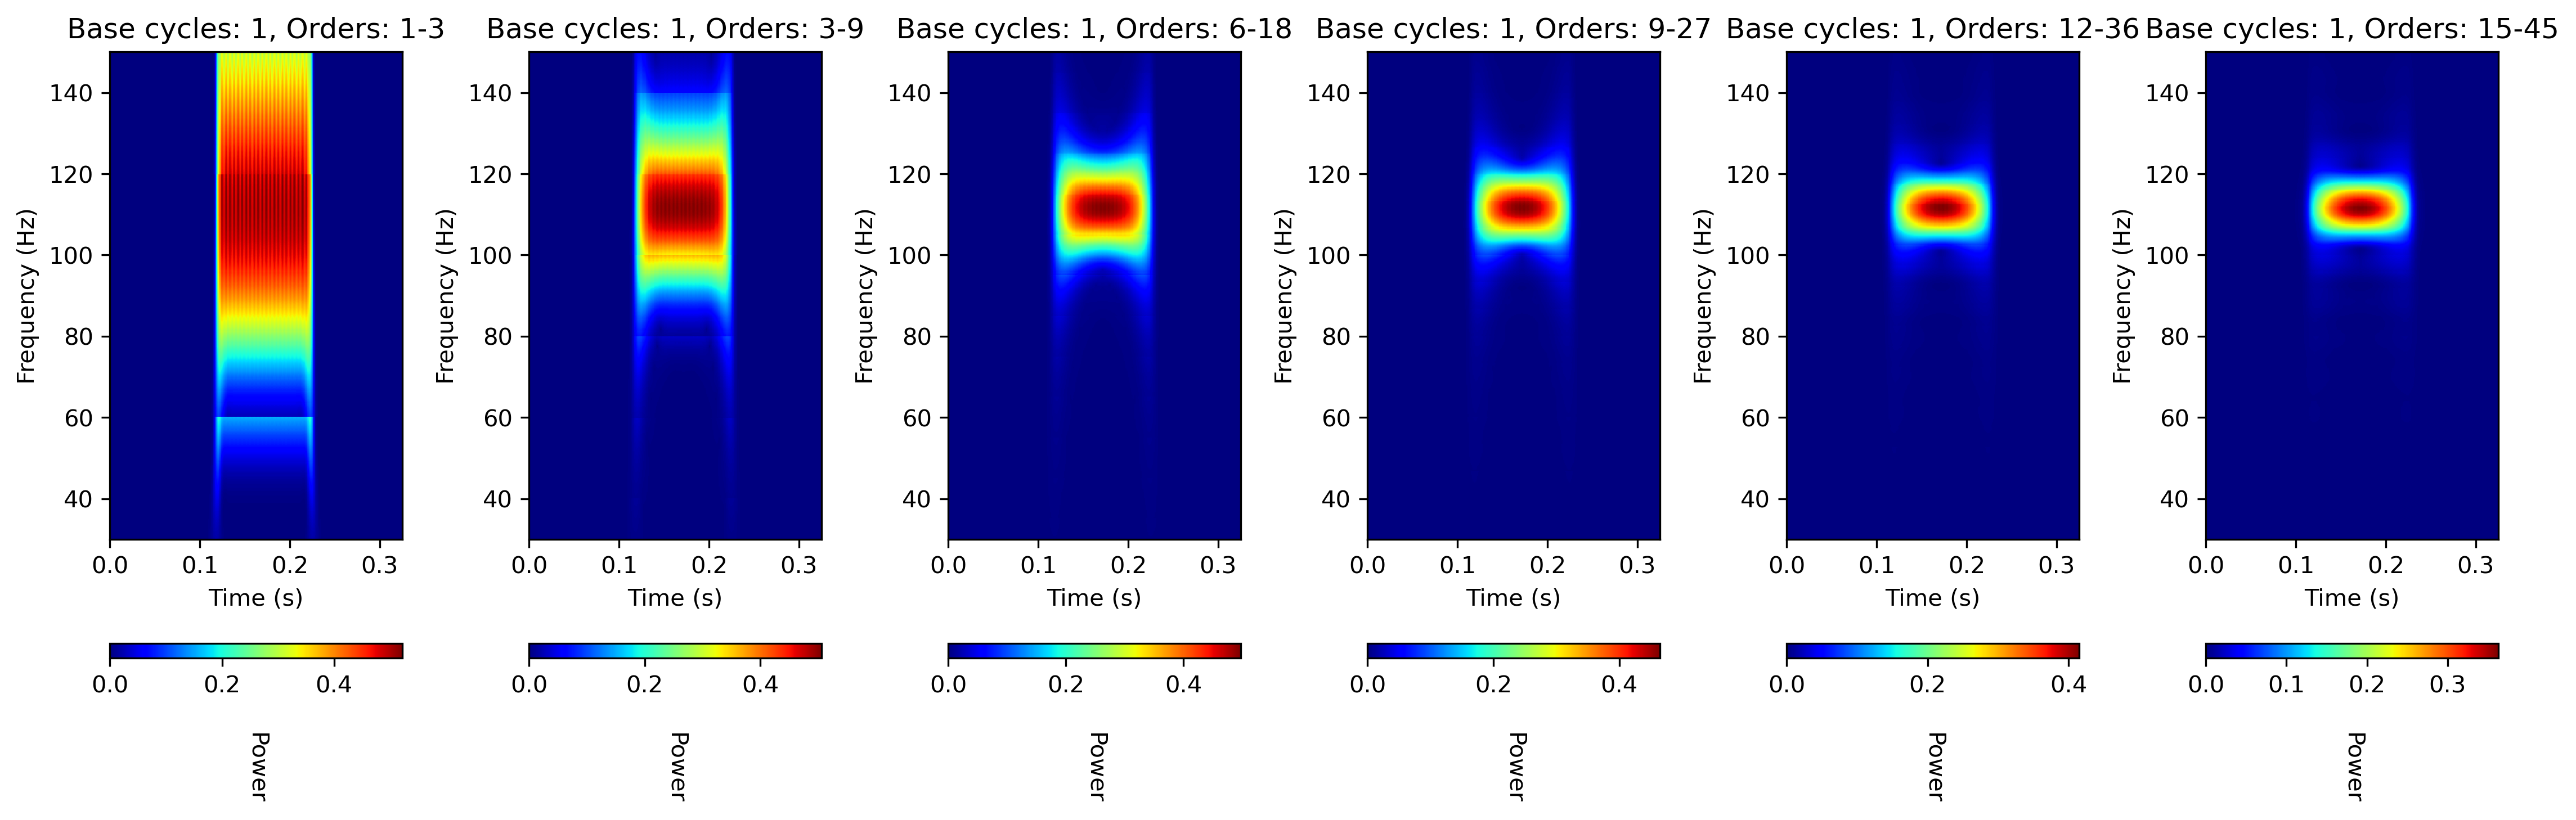

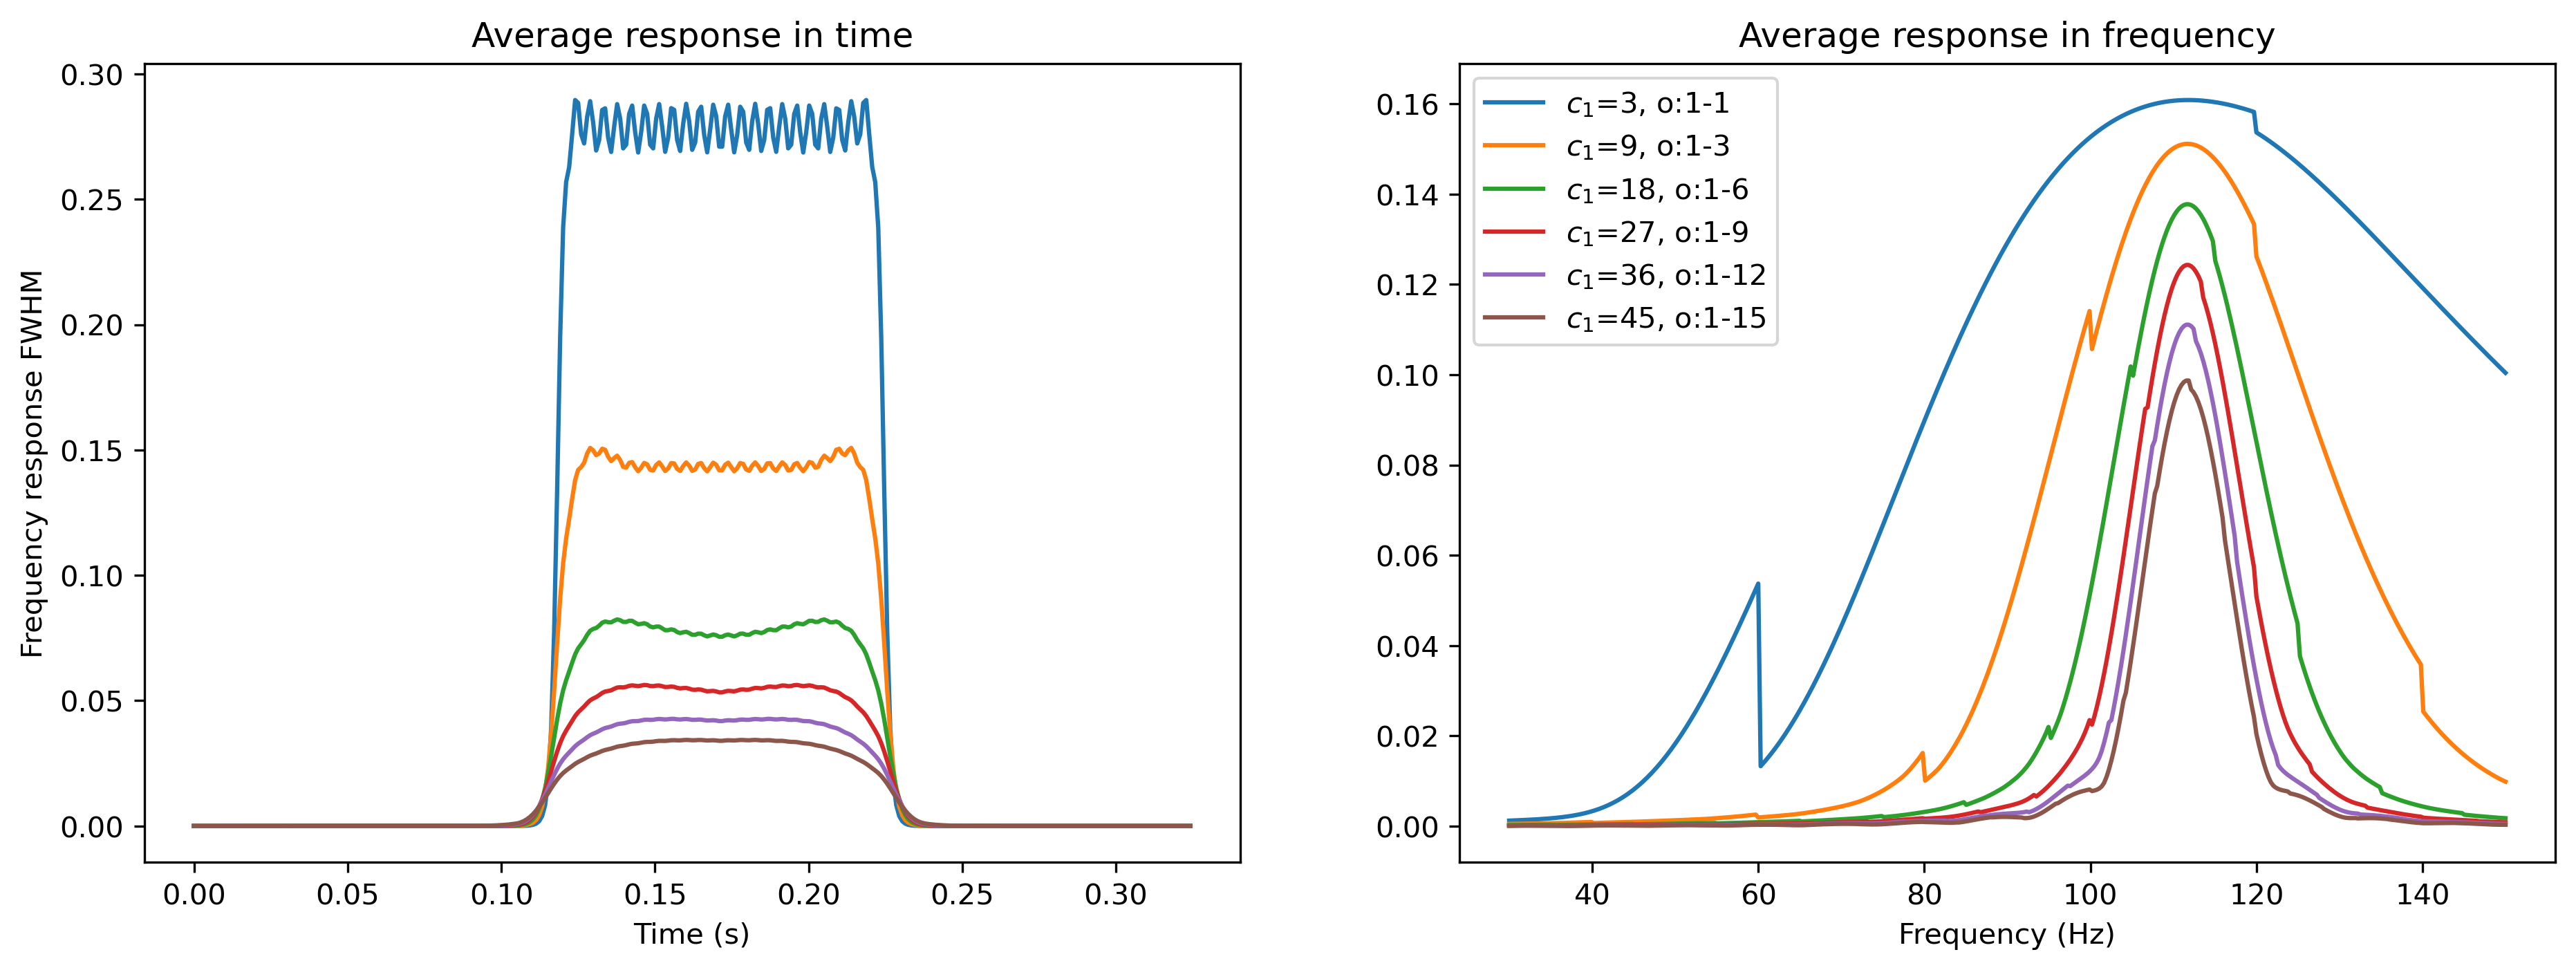

In [29]:
#params_superlet = zip([3,5,1], [1,1,5], [30,30,40])
params_superlet = [[1,1,1,1,1,1], [1,3,6,9,12,15], [3,9,18,27,36,45]]
fig, ax = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)

total_time = []
total_freq = []

for (i, (base_cycle, min_order, max_order)) in enumerate(zip(*params_superlet)):
    wv, scalogram = superlet.adaptive_superlet_transform(signal, freqs, sampling_freq=fs, 
                                        base_cycle=base_cycle, min_order=min_order, max_order=max_order, mode="mul")
    
    im = ax[i].imshow(jnp.abs(scalogram)**2, aspect='auto', cmap="jet", interpolation="none", origin="lower", extent=[0, len(signal)/fs, freqs[0], freqs[-1]])
    ax[i].set_title(f"Base cycles: {base_cycle}, Orders: {min_order}-{max_order}")
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Frequency (Hz)")
    
    cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
    cbar.set_label('Power', rotation=270, labelpad=15)  # Etiqueta de la colorbar
    
    scalogram_2 = np.abs(scalogram)**2    
    
    if np.any(np.isnan(jnp.abs(scalogram)**2)) or np.any(np.isinf(jnp.abs(scalogram)**2)):
        scalogram_2 = np.nan_to_num(jnp.abs(scalogram)**2)
 
    total_scalogram_superlet.append(scalogram_2)
    #scalogram_2 = scalogram_2 * freqs[:, np.newaxis]  

    # Create time (each column is a time instant)
    time = np.arange(scalogram_2.shape[1]) / fs
    
    total_time.append(time)
    total_freq.append(freqs)
    
plt.tight_layout()
    
res_superlet = superlet.compute_avg_response_resolution(total_scalogram_superlet, total_time, total_freq, [f'$c_1$={c3}, o:{c1}-{c2}' for c1, c2, c3 in zip(*params_superlet)])   

## STFT PARAMETERS (window = duration/cycles) = 38, 200, 413 ms

In [30]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

In [31]:
total_scalogram_stft = []

Ventanas equivalentes --> W = Ciclos * (fs/fc)

In [ ]:
from scipy.signal import stft
from scipy.signal import windows

# Parámetros de la STFT con ventanas de 38 ms, 200 ms, y 413 ms (convertido a muestras)
windows_ms = [20, 60, 120, 180, 240, 300]
#windows_samples = [int((w / 1000) * fs) for w in windows_ms]  # Convertir a muestras

fig, ax = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)

total_time = []
total_freq = []

for i, w in enumerate(windows_ms):
    # Blackman window
    window = windows.blackman(w)
    
    # Hacer que la f de la stft tenga el mismo tamaño que las demás
    nfft = 2 * (len(freqs))
    
    # Realizar la STFT con la ventana Blackman y superposición del 50%
    #f, t, Zxx = stft(signal, fs, window=window, nfft=nfft, nperseg=w, noverlap=w//2, padded=True, scaling='psd')
    f, t, Zxx = stft(signal, fs=fs, window='blackman', nperseg=w, noverlap=w-1, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')
    
    # ax[i].pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap='jet')
    
    # Power (squared amplitude)
    Zxx_power = np.abs(Zxx) ** 2
    
    pcm = ax[i].pcolormesh(t,f, Zxx_power, shading='gouraud', cmap='jet')
    
    ax[i].set_title(f'STFT con ventana de {w} muestras ({w * 1000 // fs} ms)')
    ax[i].set_ylabel('Frecuencia [Hz]')
    ax[i].set_xlabel('Tiempo [s]')
    
    cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
    cbar.set_label('Power', rotation=0, labelpad=15)  # Etiqueta de la colorbar

    #fig.colorbar(pcm, ax=ax[i], label='Potencia')
    ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
    
    
    scalogram_2 = Zxx_power
    
    if np.any(np.isnan(jnp.abs(Zxx)**2)) or np.any(np.isinf(jnp.abs(Zxx)**2)):
        scalogram_2 = np.nan_to_num(jnp.abs(Zxx)**2)
        
    total_scalogram_stft.append(scalogram_2)

    # Create time (each column is a time instant)
    time = np.linspace(t[0], t[-1], scalogram_2.shape[1])
    freq = np.linspace(f[0], f[-1], scalogram_2.shape[0])
    
    total_time.append(time)
    total_freq.append(freq)
    
plt.tight_layout()
    
res_stft = superlet.compute_avg_response_resolution(total_scalogram_stft, total_time, total_freq, windows_ms, stft=[freqs[0],freqs[-1]])   

# COMPUTE RESOLUTION (half-width of the frequency and time peak)

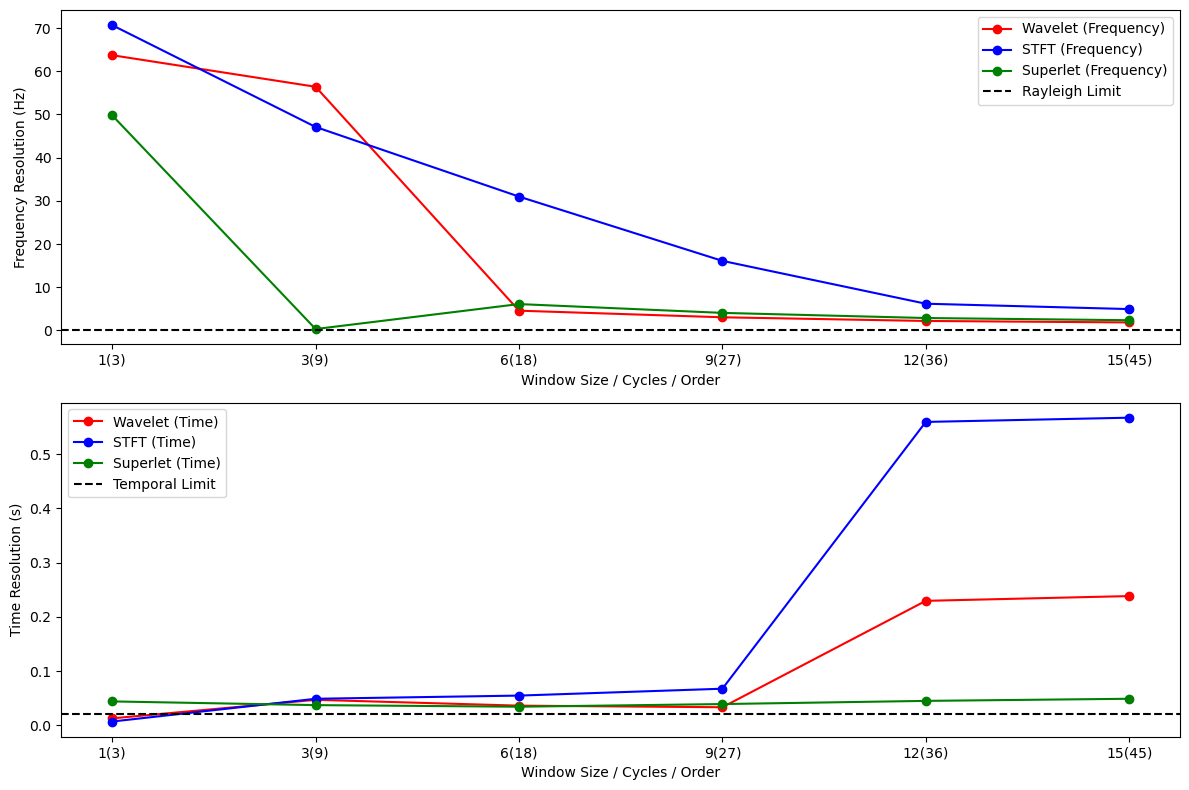

In [62]:
# Graficar resoluciones para SNR específico
selected_snr_index = 2  # Índice para SNR = 0
rayleigh_limit = 1 / (4 * np.pi)

params = ['1(3)', '3(9)','6(18)','9(27)','12(36)','15(45)']

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(params, [r[1] for r in res_wavelet], 'ro-', label="Wavelet (Frequency)")
plt.plot(params, [r[1] for r in res_stft], 'bo-', label="STFT (Frequency)")
plt.plot(params, [r[1] for r in res_superlet], 'go-', label="Superlet (Frequency)")
plt.axhline(rayleigh_limit, color='k', linestyle='--', label="Rayleigh Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Frequency Resolution (Hz)")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(params, [r[0] for r in res_wavelet], 'ro-', label="Wavelet (Time)")
plt.plot(params, [r[0] for r in res_stft], 'bo-', label="STFT (Time)")
plt.plot(params, [r[0] for r in res_superlet], 'go-', label="Superlet (Time)")
plt.axhline(1/50, color='k', linestyle='--', label="Temporal Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Time Resolution (s)")
plt.legend()

plt.tight_layout()
plt.show()